In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb;
import lightgbm as lgb
from sklearn import linear_model
pd.set_option('display.max_columns', 100)
pd.options.display.max_rows = 999

In [109]:
def process_time(df):
        
    df['weekday_sin'] = np.sin(1 * np.pi * df['WeekDay'].astype(np.float64) / 7)
    df['weekday_cos'] = np.cos(1 * np.pi * df['WeekDay'].astype(np.float64) / 7)
    
    # yday has period of 365
    df['day_of_year_sin'] = np.sin(1 * np.pi * df['DayOfYear'].astype(np.float64) / 365)
    df['day_of_year_cos'] = np.cos(1 * np.pi * df['DayOfYear'].astype(np.float64) / 365)
    
    # month has period of 12
    df['month_sin'] = np.sin(1 * np.pi * df['Month'].astype(np.float64) / 12)
    df['month_cos'] = np.cos(1 * np.pi * df['Month'].astype(np.float64) / 12)
    
    # time has period of 24
    df['hour_sin'] = np.sin(1 * np.pi * df['Hour'].astype(np.float64) / 24)
    df['hour_cos'] = np.cos(1 * np.pi * df['Hour'].astype(np.float64) / 24)

    return df

import calendar
def get_day_name(weekday):
    days = list(calendar.day_name)
    return days[weekday]

def today_is_off(df):
    day_off = []
    for i in range(len(df)):
        wkday = df['WeekDay'][i]
        if (wkday == 4 and df['friday_is_day_off'][i] == 1):
            day_off.append(1)
        elif (wkday == 5 and df['saturday_is_day_off'][i] == 1):
            day_off.append(1)
        elif (wkday == 6 and df['sunday_is_day_off'][i] == 1):
            day_off.append(1)
        else:
            day_off.append(0)
    df['day_is_off'] = day_off
    return df

def process_temperature(df):
    df['temperature_filled'] = 0
    #df = df.sort_values('timestamp')
    temp_month = df[['Month','Hour','temperature']].groupby(['Month','Hour']).mean()
    temp_month['Month'] = temp_month.index.get_level_values('Month')
    temp_month['Hour'] = temp_month.index.get_level_values('Hour')
    temp_month.columns = ['temp','Month','Hour']    
    for i in df['series_id'].unique():
        #print('series: ' + str(i))
        data = df[df.series_id == i]
        # fill na temperatures with monthly mean
        if len(data[~(data.temperature.isnull())]) == 0:
            data = data.join(temp_month, on=['Month','Hour'], how='inner', lsuffix='_l', rsuffix='_r')
            data['temperature'] = data.temp
        data.fillna(method='ffill',inplace=True)
        data.fillna(data.temperature.mean(),inplace=True)
        df['temperature_filled'][df.series_id == i] = data.temperature
    return df

def feature_eng(dataframe):
    df = dataframe
    df['WeekDay'] = df['timestamp'].dt.dayofweek
    df['Month'] = df['timestamp'].dt.month
    df['DayMonth'] = df['timestamp'].dt.day
    df['DayOfYear'] = df['timestamp'].dt.dayofyear
    df['Hour'] = df['timestamp'].dt.hour
    df = process_time(df)
    df = df.replace({'WeekDay' : { 1:0, 2:0,3:0,4:0}}).replace({'WeekDay' : { 5:1,6:1}})
    df.rename(columns={'WeekDay':'day_is_off'}, inplace=True)
    df['WeekDay'] = df['timestamp'].dt.weekday

    df = process_temperature(df)
    df['base_temperature_code'] = np.where(df['temperature_filled']<=15, 1, 0)
    temp = df.pop('temperature_filled')
    df.drop(['temperature'],axis=1,inplace=True)
    df['temperature'] = temp
    return df

def calc_statistics(df):
    series = df.series_id.unique()
    day_work_list = []
    day_off_list = []
    for i in series:     
        data = df[df.series_id == i]
        day_work_list.append(data.groupby(['day_is_off'])['consumption'].mean().values[0])
        try:
            day_off_list.append(data.groupby(['day_is_off'])['consumption'].mean().values[1])
        except:
            day_off_list.append(np.nan)
    mean_diff_work = [series,day_work_list,day_off_list]
    mean_diff_work_pd = pd.DataFrame(mean_diff_work).T
    mean_diff_work_pd.columns = ['series_id','consumption_workday','consumption_off_day']
    mean_diff_work_pd['diff_mean'] = mean_diff_work_pd.consumption_workday - mean_diff_work_pd.consumption_off_day
    mean_diff_work_pd['percent_from_off_day_to_workday'] = mean_diff_work_pd.diff_mean/mean_diff_work_pd.consumption_workday

    mean_std_consumption = pd.DataFrame([df.groupby('series_id').std().consumption,df.groupby('series_id').mean().consumption]).T
    mean_std_consumption.columns = ['consumption_sd', 'consumption_mean']
    mean_std_consumption['percent_sd_from_mean'] = mean_std_consumption.consumption_sd/mean_std_consumption.consumption_mean
    mean_std_consumption['series_id'] = mean_std_consumption.index
    series_stats = mean_diff_work_pd.merge(mean_std_consumption,how='inner', on=['series_id']).sort_values(by=['consumption_mean'])
    return series_stats

# load data

In [101]:
# source
train = pd.read_csv('consumption_train.csv', index_col=0, parse_dates=['timestamp'])
meta = pd.read_csv('meta.csv')
test = pd.read_csv('cold_start_test.csv', index_col=0, parse_dates=['timestamp'])
sub = pd.read_csv('submission_format.csv', index_col=0, parse_dates=['timestamp'])
sub_original = sub.copy()
print('number of series in train: ' + str(len(train.series_id.unique())) + ', and number of rows: ' + str(len(train)) )
print('number of series in test: ' + str(len(test.series_id.unique())) + ', and number of rows: ' + str(len(test)) )
print('number of overlapping series train test: ' + str(len(train[train.series_id.isin(test.series_id)])))
print('---')
print('number of overlapping series test & submission: ' + str(len(test.series_id.isin(sub.series_id))))

number of series in train: 758, and number of rows: 509376
number of series in test: 625, and number of rows: 111984
number of overlapping series train test: 0
---
number of overlapping series test & submission: 111984


# feature eng. and fill na

In [110]:
test = feature_eng(test).sort_index()
sub = feature_eng(sub).sort_index()
#test[test.temperature.isnull()]
#sub[sub.temperature == 0] = sub.temperature.mean()
#test2[test2.temperature==0]

#test2[test2.series_id ==102920]#

# df = test[['series_id','temperature']]
# grouped_df = df.groupby(['series_id']).sum()
# grouped_df
#grouped_df[grouped_df['temperature'] != 0].index

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWar

# data crunching normalizing and other stuff

In [111]:
train_merged = train.merge(meta,  how='inner', on=['series_id'])
train_merged['WeekDay'] = train_merged['timestamp'].dt.weekday
train_merged['Month'] = train_merged['timestamp'].dt.month
train_merged['DayMonth'] = train_merged['timestamp'].dt.day
train_merged['DayOfYear'] = train_merged['timestamp'].dt.dayofyear
train_merged['Hour'] = train_merged['timestamp'].dt.hour
train_merged.friday_is_day_off = train_merged.friday_is_day_off.astype("category").cat.codes
train_merged.saturday_is_day_off = train_merged.saturday_is_day_off.astype("category").cat.codes
train_merged.sunday_is_day_off = train_merged.sunday_is_day_off.astype("category").cat.codes
train_merged['base_temperature_code'] = train_merged.base_temperature.astype("category").cat.codes
train_merged = today_is_off(train_merged)
train_merged['surface_code'] = train_merged.surface.astype("category").cat.codes
train_merged['surface'] = train_merged.surface.replace('x-small','small')
train_merged = process_time(train_merged)
train_merged.drop(list(train_merged.filter(regex = 'is_day_off')), axis = 1, inplace = True)

In [112]:
df = test[['series_id','temperature']]
grouped_df = df.groupby(['series_id']).sum()
grouped_df[grouped_df['temperature'] != 0].index

df = train_merged[['series_id','temperature']]
grouped_df = df.groupby(['series_id']).sum()
grouped_df[grouped_df['temperature'] != 0].index

train_final = train_merged[train_merged.series_id.isin(grouped_df[grouped_df['temperature'] != 0].index)]
train_final = process_temperature(train_final)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic

# show dependencies

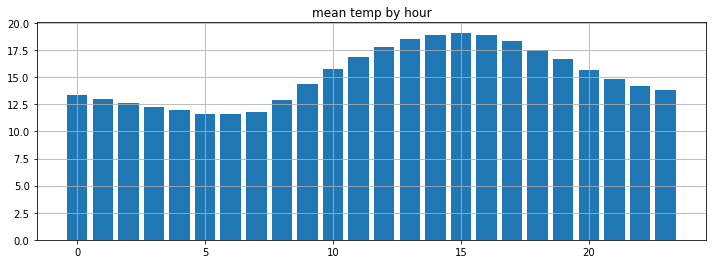

In [113]:
plt.rc("figure",figsize=(12,4))
bars = train_final.groupby(['Hour'])['temperature'].mean()
plt.bar(bars.index,bars)
plt.title('mean temp by hour')
plt.grid()

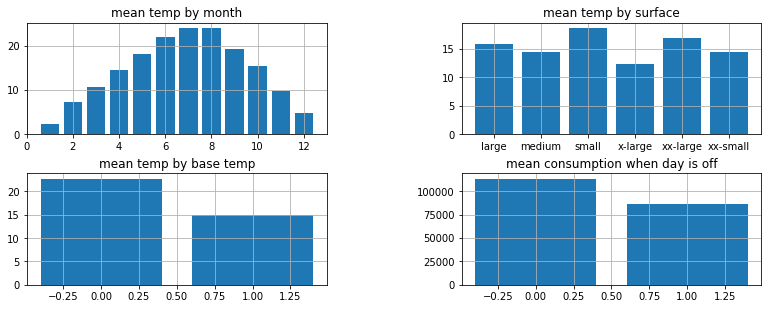

In [115]:
plt.rc("figure",figsize=(12,4))
plt.subplot(221)
bars = train_final.groupby(['Month'])['temperature'].mean()
plt.bar(bars.index,bars)
plt.title('mean temp by month')
plt.grid()

plt.subplot(222)
bars = train_final.groupby(['surface'])['temperature'].mean()
plt.bar(bars.index,bars)
plt.title('mean temp by surface')
plt.grid()

plt.subplot(223)
bars = train_final.groupby(['base_temperature_code'])['temperature'].mean()
plt.bar(bars.index,bars)
plt.title('mean temp by base temp')
plt.grid()

plt.subplot(224)
bars = train_final.groupby(['day_is_off'])['consumption'].mean()
plt.bar(bars.index,bars)
plt.title('mean consumption when day is off')
plt.grid()
plt.subplots_adjust(top=0.99, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.45)
plt.show()

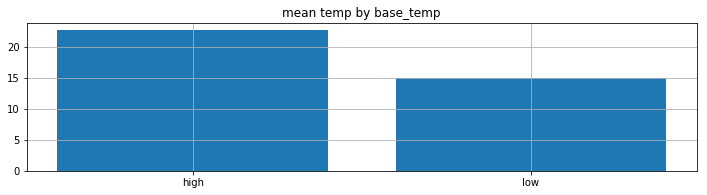

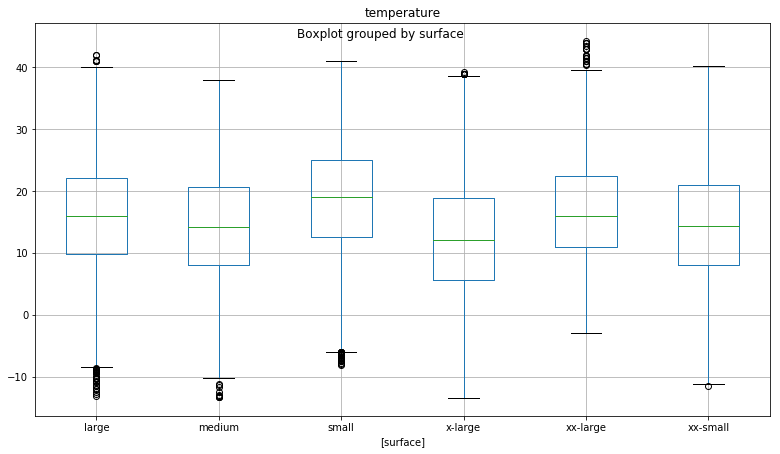

In [116]:
plt.rc("figure",figsize=(12,6))
plt.subplot(211)
bars = train_final.groupby(['base_temperature'])['temperature'].mean()
plt.bar(bars.index,bars)
plt.title('mean temp by base_temp')
plt.grid()

data = train_final[['temperature', 'surface']]
data.boxplot(by='surface')

plt.subplots_adjust(top=0.99, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.45)
plt.show()

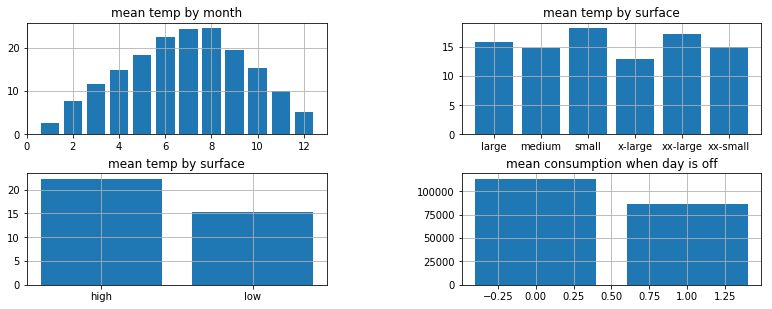

In [117]:
plt.rc("figure",figsize=(12,4))
plt.subplot(221)
bars = train_final.groupby(['Month'])['temperature_filled'].mean()
plt.bar(bars.index,bars)
plt.title('mean temp by month')
plt.grid()

plt.subplot(222)
bars = train_final.groupby(['surface'])['temperature_filled'].mean()
plt.bar(bars.index,bars)
plt.title('mean temp by surface')
plt.grid()

plt.subplot(223)
bars = train_final.groupby(['base_temperature'])['temperature_filled'].mean()
plt.bar(bars.index,bars)
plt.title('mean temp by surface')
plt.grid()

plt.subplot(224)
bars = train_final.groupby(['day_is_off'])['consumption'].mean()
plt.bar(bars.index,bars)
plt.title('mean consumption when day is off')
plt.grid()
plt.subplots_adjust(top=0.99, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.45)
plt.show()

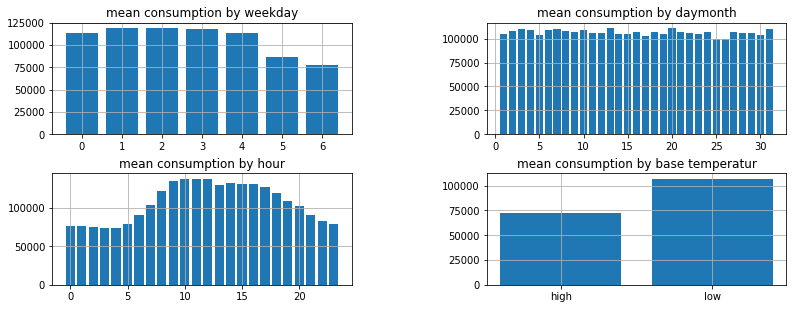

In [118]:
plt.rc("figure",figsize=(12,4))
plt.subplot(221)
bars = train_final.groupby(['WeekDay'])['consumption'].mean()
plt.bar(bars.index,bars)
plt.title('mean consumption by weekday')
plt.grid()

plt.subplot(222)
bars = train_final.groupby(['DayMonth'])['consumption'].mean()
plt.bar(bars.index,bars)
plt.title('mean consumption by daymonth')
plt.grid()

plt.subplot(223)
bars = train_final.groupby(['Hour'])['consumption'].mean()
plt.bar(bars.index,bars)
plt.title('mean consumption by hour')
plt.grid()

plt.subplot(224)
bars = train_final.groupby(['base_temperature'])['consumption'].mean()
plt.bar(bars.index,bars)
plt.title('mean consumption by base temperatur')
plt.grid()
plt.subplots_adjust(top=0.99, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.45)
plt.show()

In [119]:
import matplotlib.dates as mdates
def plot_series(df=None,index=1):
    try:
        index = int(index)
        i = df.series_id.unique()[index]
        data = df[df.series_id == i][['timestamp','consumption']].sort_values(by=['timestamp'])
        # start plotting
        fig, ax = plt.subplots()
        fig.figsize=(22,6)
        plt.grid()
        ax.xaxis.set_tick_params(rotation=60, labelsize=11)
        plt.grid(True)
        plt.plot(data.timestamp,data.consumption,linestyle =':')
        plt.plot(data.timestamp,data.consumption.rolling(window=10).mean().fillna(method='bfill'))
        myFmt = mdates.DateFormatter('%a %d.%m.%Y')
        ax.xaxis.set_major_formatter(myFmt)
        days = mdates.DayLocator()
        ax.xaxis.set_minor_locator(days)
        plt.legend(['consumption','rolling mean 10'])
        plt.title('timeseries plot for series: ' + str(i))
    except:
        print('something wrong')
from ipywidgets import interact,interactive, fixed
#plot_series(df=train_final,index=1)

interact(plot_series,df=fixed(train_final),index='1');

interactive(children=(Text(value='1', description='index'), Output()), _dom_classes=('widget-interact',))

# Show yearly seasonality?

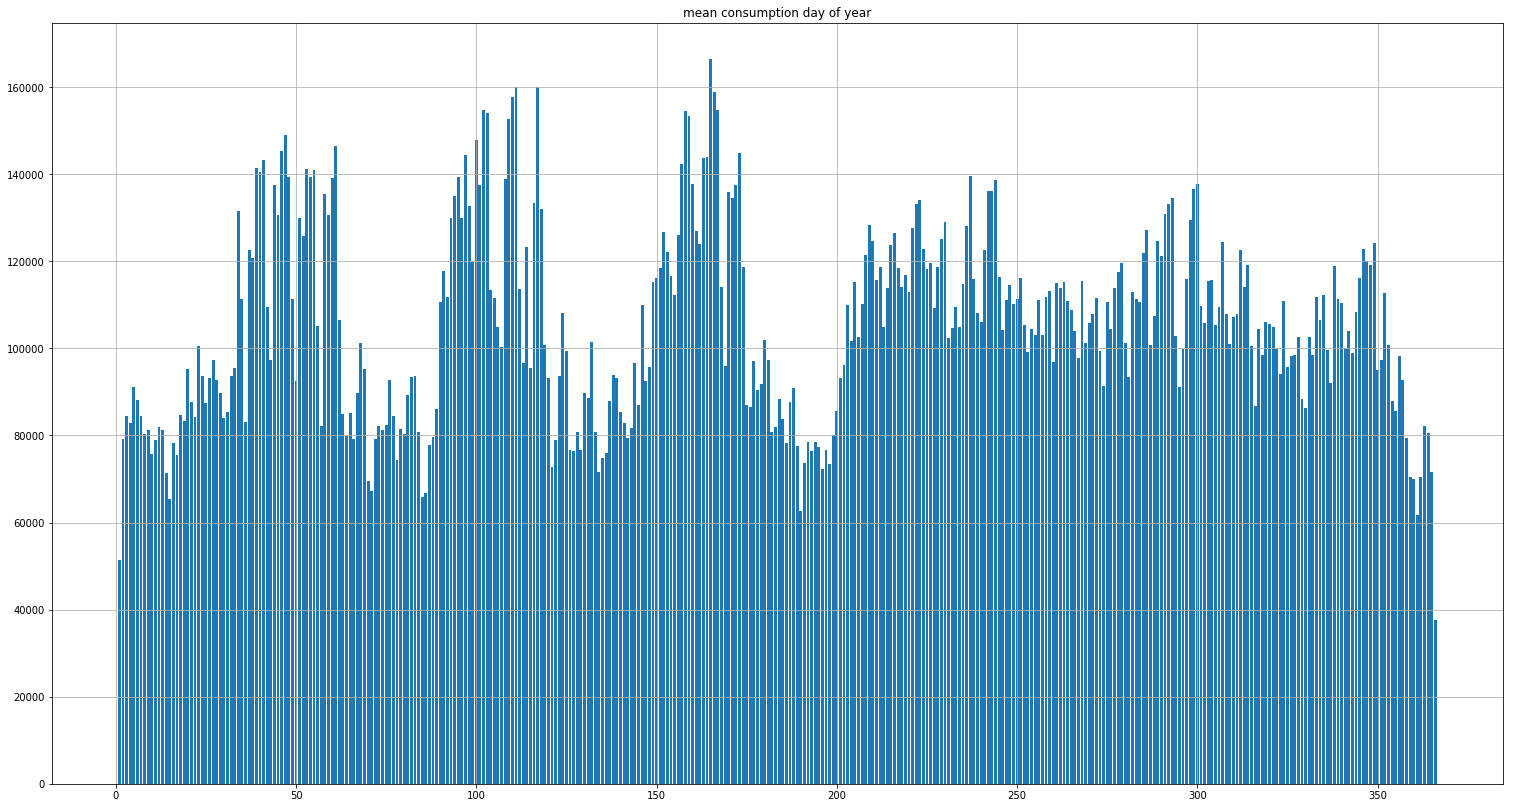

In [120]:
plt.rc("figure",figsize=(26,14))
bars = train_final.groupby(['DayOfYear'])['consumption'].mean()
plt.bar(bars.index,bars)
plt.title('mean consumption day of year')
plt.grid()
plt.show()

In [121]:
train_final.drop(['temperature','surface_code','base_temperature','surface'],axis=1,inplace=True)
print(train_final.isnull().any())
train_final.describe()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


series_id                False
timestamp                False
consumption              False
WeekDay                  False
Month                    False
DayMonth                 False
DayOfYear                False
Hour                     False
base_temperature_code    False
day_is_off               False
weekday_sin              False
weekday_cos              False
day_of_year_sin          False
day_of_year_cos          False
month_sin                False
month_cos                False
hour_sin                 False
hour_cos                 False
temperature_filled       False
dtype: bool


,series_id,consumption,WeekDay,Month,DayMonth,DayOfYear,Hour,base_temperature_code,day_is_off,weekday_sin,weekday_cos,day_of_year_sin,day_of_year_cos,month_sin,month_cos,hour_sin,hour_cos,temperature_filled
count,341376.000000,3.413760e+05,341376.000000,341376.000000,341376.000000,341376.000000,341376.000000,341376.000000,341376.000000,341376.000000,341376.000000,341376.000000,341376.000000,3.413760e+05,341376.000000,341376.000000,341376.000000,341376.000000
mean,101829.301181,1.063682e+05,3.000000,6.629499,15.697483,186.282621,11.500000,0.978346,0.253656,0.625898,0.142857,0.670192,-0.028044,6.625710e-01,-0.117048,0.635710,0.041667,15.510419
std,1019.502209,1.617297e+05,2.000003,3.269765,8.797938,99.811402,6.922197,0.145550,0.435104,0.329017,0.692527,0.286667,0.684018,2.970764e-01,0.677530,0.309633,0.705879,8.947558
min,100003.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.900969,-0.008607,-1.000000,1.224647e-16,-1.000000,0.000000,-0.991445,-13.466667
25%,100978.750000,1.513773e+04,1.000000,4.000000,8.000000,100.750000,5.750000,1.000000,0.000000,0.433884,-0.623490,0.455907,-0.690173,5.000000e-01,-0.707107,0.382683,-0.633348,9.000000
50%,101840.500000,4.693620e+04,3.000000,7.000000,16.000000,189.000000,11.500000,1.000000,0.000000,0.781831,0.222521,0.741222,-0.055917,7.071068e-01,-0.258819,0.707107,0.065263,15.333333
75%,102687.750000,1.312007e+05,5.000000,9.000000,23.000000,271.000000,17.250000,1.000000,1.000000,0.974928,0.900969,0.933837,0.646986,9.659258e-01,0.500000,0.923880,0.728668,22.166667
max,103634.000000,2.085109e+06,6.000000,12.000000,31.000000,366.000000,23.000000,1.000000,1.000000,0.974928,1.000000,0.999991,0.999963,1.000000e+00,0.965926,1.000000,1.000000,44.350000


# Check mean, sd, and differences to off-days

In [122]:
#train_stats = calc_statistics(train_final)
#test_stats = calc_statistics(test)
#train_feed = train_final.merge(train_stats,how='inner', on=['series_id'])
#test_feed = test.merge(test_stats,how='inner', on=['series_id'])

train_feed = train_final
test_feed = test
train_feed['log1p'] = train_feed.groupby('series_id')['consumption'].apply(np.log1p)
test_feed['log1p'] = test_feed.groupby('series_id')['consumption'].apply(np.log1p)
train_feed['pct_change'] = train_feed.groupby('series_id')['consumption'].apply(lambda x:x.pct_change().fillna(x.pct_change().mean()))
test_feed['pct_change'] = test_feed.groupby('series_id')['consumption'].apply(lambda x:x.pct_change().fillna(x.pct_change().mean()))

df_grouped = train_feed.groupby(['series_id'])
for c in [1,2,3,4,5,6,7,11,21]:
    # shift columns
    train_feed['log1p_shift' + str(c)] = df_grouped['log1p'].shift(c).fillna(method="backfill").fillna(0)

df_grouped = test_feed.groupby(['series_id'])
for c in [1,2,3,4,5,6,7,11,21]:
    # shift columns
    test_feed['log1p_shift' + str(c)] = df_grouped['log1p'].shift(c).fillna(method="backfill").fillna(0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

# explore test set

In [123]:
test[['series_id','timestamp']].groupby('series_id').agg(['min','max','count'])

timestamp                          
                 min                 max count
series_id                                     
100004    2015-06-30 2015-07-03 23:00:00    96
100010    2013-11-22 2013-12-03 23:00:00   288
100012    2017-07-05 2017-07-14 23:00:00   240
100020    2017-01-10 2017-01-22 23:00:00   312
100028    2014-10-09 2014-10-21 23:00:00   312
100049    2017-03-15 2017-03-19 23:00:00   120
100050    2014-08-08 2014-08-17 23:00:00   240
100054    2017-06-21 2017-06-26 23:00:00   144
100062    2017-03-31 2017-04-08 23:00:00   216
100069    2016-07-01 2016-07-03 23:00:00    72
100071    2014-06-20 2014-06-27 23:00:00   192
100072    2016-04-20 2016-04-24 23:00:00   120
100074    2013-10-09 2013-10-15 23:00:00   168
100078    2015-01-02 2015-01-05 23:00:00    96
100082    2017-09-26 2017-10-06 23:00:00   264
100090    2016-01-07 2016-01-07 23:00:00    24
100094    2016-07-02 2016-07-09 23:00:00   192
100096    2017-06-28 2017-07-11 23:00:00   336
100099    2015-11-26 2015-11-27 23:00:00    48
100104    2016-12-09 2016-12-14 23:00:00   144
100110    2014-12-04 2014-12-04 23:00:00    24
100111    2017-06-28 2017-07-02 23:00:00   120
100128    2013-05-15 2013-05-15 23:00:00    24
100135    2017-04-28 2017-05-03 23:00:00   144
100146    2017-09-21 2017-09-28 23:00:00   192
100147    2017-04-28 2017-04-30 23:00:00    72
100148    2016-07-11 2016-07-14 23:00:00    96
100150    2016-06-22 2016-06-22 23:00:00    24
100164    2015-01-21 2015-01-25 23:00:00   120
100167    2016-03-10 2016-03-22 23:00:00   312
100202    2017-01-20 2017-01-22 23:00:00    72
100203    2017-01-24 2017-02-03 23:00:00   264
100204    2016-05-07 2016-05-20 23:00:00   336
100205    2015-11-24 2015-12-01 23:00:00   192
100229    2016-05-21 2016-06-01 23:00:00   288
100235    2017-02-10 2017-02-17 23:00:00   192
100240    2017-04-28 2017-05-07 23:00:00   240
100242    2016-03-29 2016-04-04 23:00:00   168
100243    2016-06-10 2016-06-13 23:00:00    96
100245    2014-02-02 2014-02-07 23:00:00   144
100246    2016-02-27 2016-03-07 23:00:00   240
100252    2017-04-07 2017-04-13 23:00:00   168
100256    2016-01-25 2016-02-07 23:00:00   336
100257    2014-09-10 2014-09-17 23:00:00   192
100274    2015-06-09 2015-06-20 23:00:00   288
100277    2016-11-11 2016-11-16 23:00:00   144
100280    2016-09-22 2016-10-02 23:00:00   264
100289    2017-05-16 2017-05-17 23:00:00    48
100290    2017-07-04 2017-07-05 23:00:00    48
100296    2014-03-30 2014-04-07 23:00:00   216
100306    2016-05-25 2016-05-30 23:00:00   144
100310    2014-10-17 2014-10-27 23:00:00   264
100311    2015-03-04 2015-03-09 23:00:00   144
100335    2015-08-26 2015-09-02 23:00:00   192
100338    2014-01-29 2014-02-07 23:00:00   240
100350    2015-10-30 2015-11-09 23:00:00   264
100351    2015-03-27 2015-04-08 23:00:00   312
100358    2017-03-02 2017-03-11 23:00:00   240
100360    2015-05-02 2015-05-14 23:00:00   312
100365    2014-10-15 2014-10-18 23:00:00    96
100366    2017-05-06 2017-05-06 23:00:00    24
100369    2017-05-20 2017-05-27 23:00:00   192
100373    2016-09-27 2016-09-28 23:00:00    48
100376    2016-07-15 2016-07-25 23:00:00   264
100380    2017-02-09 2017-02-21 23:00:00   312
100389    2017-04-14 2017-04-14 23:00:00    24
100393    2014-02-27 2014-03-09 23:00:00   264
100398    2013-10-30 2013-11-06 23:00:00   192
100401    2016-01-25 2016-02-07 23:00:00   336
100402    2017-10-02 2017-10-10 23:00:00   216
100409    2016-05-13 2016-05-20 23:00:00   192
100416    2017-06-22 2017-06-25 23:00:00    96
100432    2015-12-11 2015-12-23 23:00:00   312
100447    2016-08-05 2016-08-17 23:00:00   312
100454    2016-03-16 2016-03-19 23:00:00    96
100466    2016-05-16 2016-05-26 23:00:00   264
100472    2015-10-30 2015-11-03 23:00:00   120
100477    2016-04-09 2016-04-19 23:00:00   264
100485    2017-10-21 2017-10-23 23:00:00    72
100486    2015-03-07 2015-03-16 23:00:00   240
100491    2017-02-24 2017-03-06 23:00:00   264
100492    2014-08-10 2014-08-14 23:00:00   120
100497    2016-0

In [124]:
test[['series_id','consumption']].groupby('series_id').agg(['count','mean','std'])

consumption                             
                count          mean            std
series_id                                         
100004             96  3.450545e+05   70222.245060
100010            288  1.111928e+03    1533.729409
100012            240  1.416395e+05   79667.923863
100020            312  2.444057e+04   22324.501536
100028            312  4.893916e+04   19130.926368
100049            120  3.650893e+03    3688.928529
100050            240  3.672166e+05  120108.521261
100054            144  5.266071e+05  164047.673107
100062            216  3.346456e+05  166931.931730
100069             72  6.373058e+04   10404.460009
100071            192  2.303299e+04   24133.652410
100072            120  1.512446e+05  103409.012818
100074            168  3.454646e+05  138376.773258
100078             96  3.248075e+03     944.874441
100082            264  3.053407e+04    4405.197496
100090             24  1.239798e+04   16582.954306
100094            192  3.364941e+04   26688.154742
100096            336  5.482833e+04   41155.213190
100099             48  4.463288e+04    3557.580052
100104            144  2.161517e+04   16258.501552
100110             24  4.365604e+04   18620.699611
100111            120  2.430727e+04    5202.240466
100128             24  1.232919e+04    9863.763466
100135            144  1.482599e+05    7748.294218
100146            192  7.877635e+04   25818.618738
100147             72  3.390276e+05  346355.434110
100148             96  3.774584e+05   77584.070915
100150             24  2.816517e+04   12631.985163
100164            120  1.591253e+03    1085.922507
100167            312  1.451763e+05   23776.475217
100202             72  1.686987e+05  210707.401289
100203            264  8.022889e+03    2117.357310
100204            336  9.362282e+04   53828.132610
100205            192  2.323747e+05  181600.850506
100229            288  3.168452e+04    8222.704238
100235            192  2.295852e+04   10431.192972
100240            240  1.610051e+05   68075.522837
100242            168  4.382553e+04    3985.535259
100243             96  6.747074e+04   62974.374958
100245            144  2.636250e+04       0.000000
100246            240  1.615125e+04    7544.103816
100252            168  2.289614e+04    5779.414896
100256            336  4.784510e+04   25839.822208
100257            192  2.897637e+05  101396.349170
100274            288  2.390746e+05  194021.512257
100277            144  2.484561e+05  232810.627254
100280            264  5.995919e+02     574.700069
100289             48  4.122243e+04   12516.850328
100290             48  4.798525e+05   53837.936103
100296            216  2.508625e+04      22.177828
100306            144  1.315511e+05   47794.136182
100310            264  2.118076e+04   16863.212902
100311            144  8.110627e+05  316959.785856
100335            192  1.637211e+05   77686.337156
100338            240  1.100252e+05   98048.933220
100350            264  3.532513e+05   92742.108509
100351            312  1.700288e+04    7342.939620
100358            240  1.680886e+04    7992.538913
100360            312  1.246372e+05   47312.031963
100365             96  2.283349e+04   18238.850222
100366             24  2.471570e+04    7302.733790
100369            192  2.007199e+04    6470.600431
100373             48  2.336230e+04    8416.028526
100376            264  1.080599e+04    5307.932436
100380            312  4.086471e+04   15201.712393
100389             24  2.130049e+03     421.664890
100393            264  4.498448e+04   20467.720237
100398            192  9.977332e+03    7589.528874
100401            336  2.387998e+04   53926.512588
100402            216  2.463887e+05  161477.420278
100409            192  1.218758e+03     513.382907
100416             96  2.677094e+04   11112.200978
100432            312  3.768901e+05  314757.517845
100447            312  1.132655e+05   95051.672558
100454             96  3.596748e+05  206207.504492
100466            264  4.027850e

In [125]:
interact(plot_series,df=fixed(test),index='1');

interactive(children=(Text(value='1', description='index'), Output()), _dom_classes=('widget-interact',))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3103: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


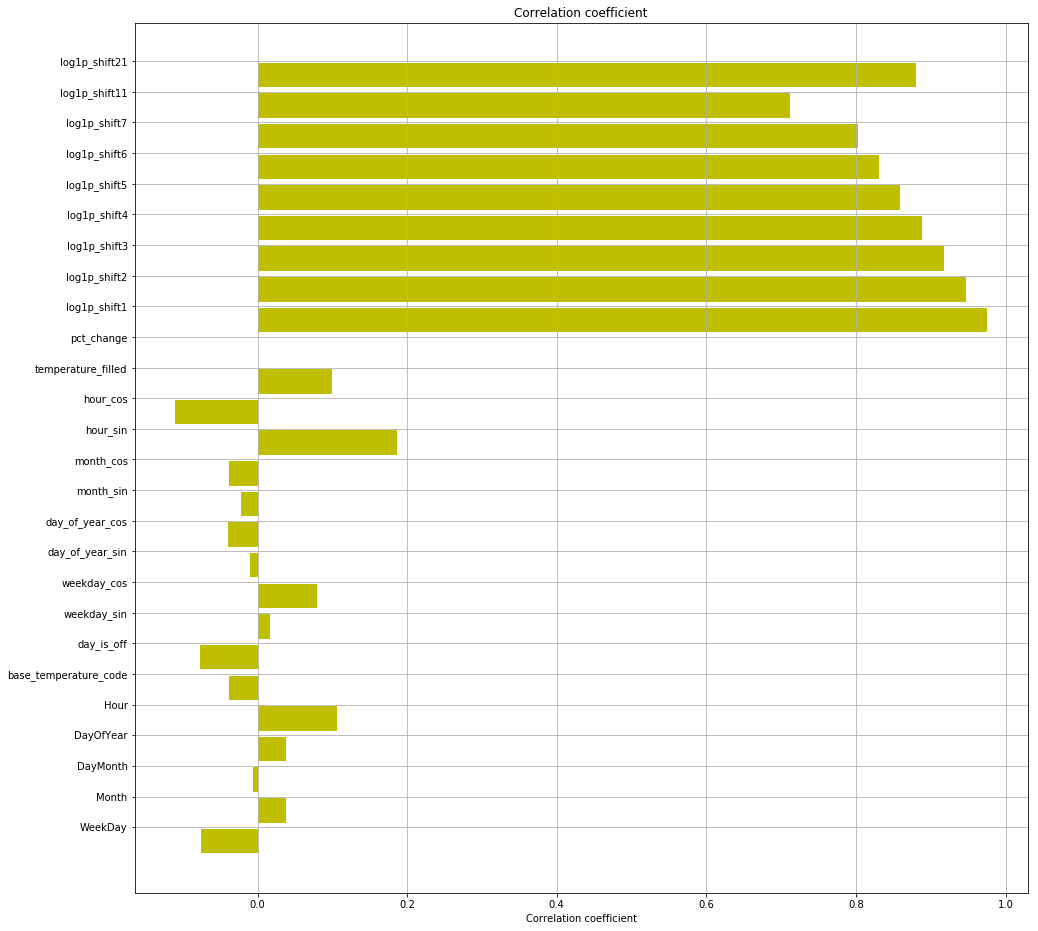

In [126]:
df = train_feed.dropna()
# Now let us look at the correlation coefficient of each of these variables
x_cols = [col for col in df.columns if col not in ['timestamp','consumption','series_id','log1p']]

target_col = 'log1p'
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df[target_col].values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(16,16))
plt.grid(True)
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.show()


# prepare for prediction

In [127]:
train_data = train_feed[['series_id','WeekDay','DayMonth','Hour','base_temperature_code','day_is_off','weekday_sin','day_of_year_sin',
                         'month_sin','hour_sin','temperature_filled','log1p','log1p_shift1','log1p_shift2','log1p_shift3',
                         'log1p_shift4','log1p_shift5','log1p_shift6','log1p_shift7','log1p_shift11','log1p_shift21']]

test_data = test_feed[['series_id','WeekDay','DayMonth','Hour','base_temperature_code','day_is_off','weekday_sin','day_of_year_sin',
                         'month_sin','hour_sin','temperature','log1p','log1p_shift1','log1p_shift2','log1p_shift3',
                         'log1p_shift4','log1p_shift5','log1p_shift6','log1p_shift7','log1p_shift11','log1p_shift21']]

Text(0.5,1,'timeseries plot for series: 102969')

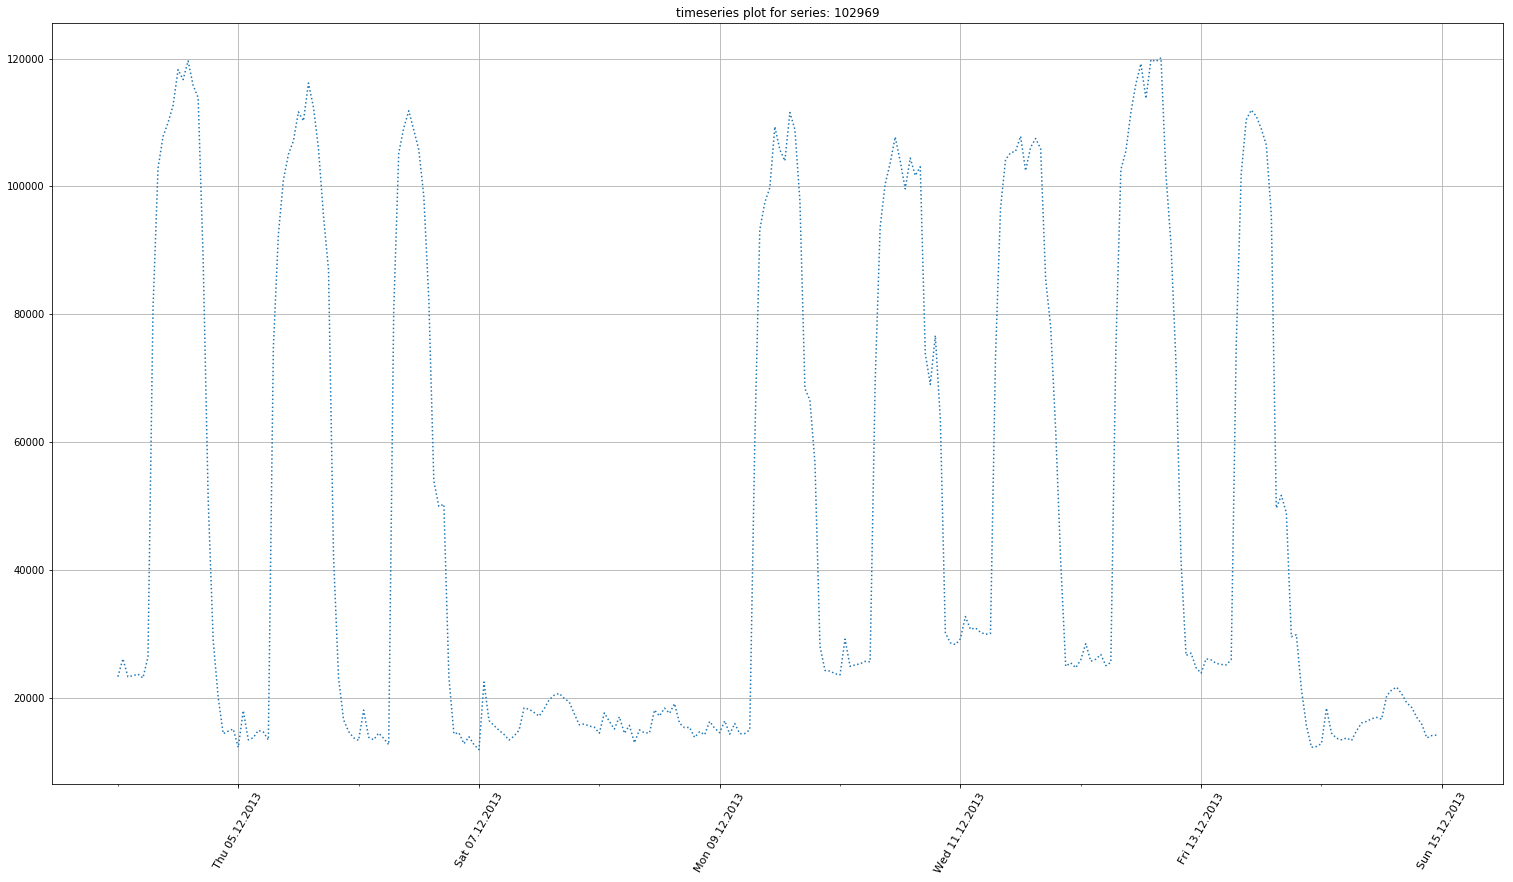

In [128]:
df = test_feed
index = 2
i = df.series_id.unique()[index]
data = df[df.series_id == i][['timestamp','consumption']].sort_values(by=['timestamp'])
# start plotting
fig, ax = plt.subplots()
fig.figsize=(22,4)
plt.grid()
ax.xaxis.set_tick_params(rotation=60, labelsize=11)
plt.grid(True)
plt.plot(data.timestamp,data.consumption,linestyle =':')
#plt.plot(data.timestamp,data.consumption.rolling(window=10).mean().fillna(method='bfill'))
myFmt = mdates.DateFormatter('%a %d.%m.%Y')
ax.xaxis.set_major_formatter(myFmt)
days = mdates.DayLocator()
ax.xaxis.set_minor_locator(days)
plt.title('timeseries plot for series: ' + str(i))

Text(0.5,1,'timeseries plot for series: 102969')

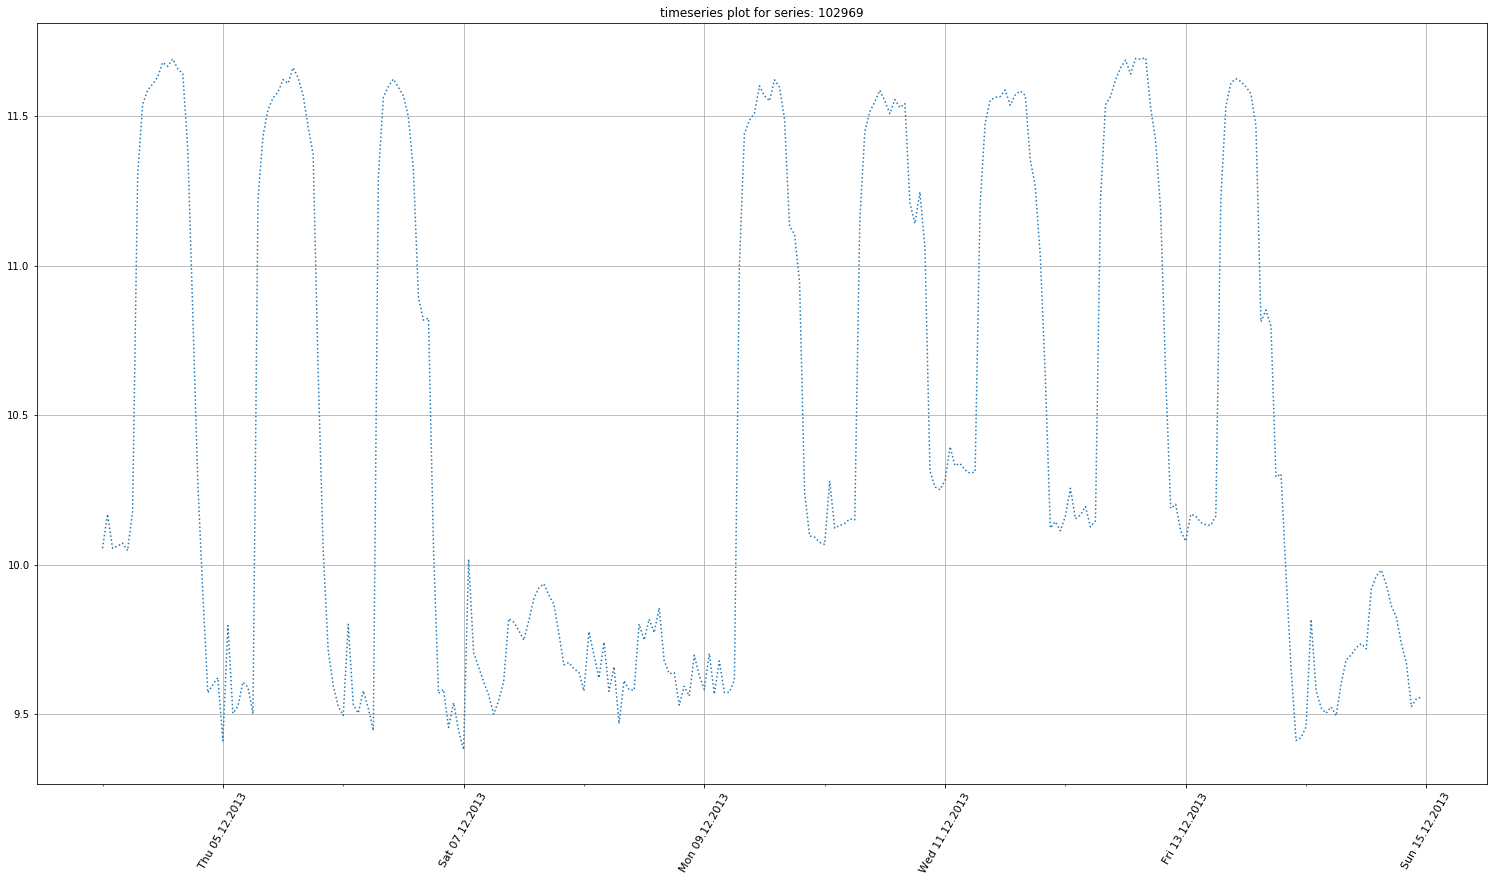

In [129]:
df = test_feed
index = 2
i = df.series_id.unique()[index]
data = df[df.series_id == i][['timestamp','log1p']].sort_values(by=['timestamp'])
# start plotting
fig, ax = plt.subplots()
fig.figsize=(22,6)
plt.grid()
ax.xaxis.set_tick_params(rotation=60, labelsize=11)
plt.grid(True)
plt.plot(data.timestamp,np.ravel((data['log1p'].values)),linestyle =':')
#plt.plot(data.timestamp,data.pct_change.rolling(window=10).mean().fillna(method='bfill'))
myFmt = mdates.DateFormatter('%a %d.%m.%Y')
ax.xaxis.set_major_formatter(myFmt)
days = mdates.DayLocator()
ax.xaxis.set_minor_locator(days)
plt.title('timeseries plot for series: ' + str(i))

In [130]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.cross_validation import *
import sklearn.feature_selection as fs

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# hyper param search for ExtraTrees

In [131]:
df = test_data
prediction_step = -1

y_train = df['log1p'].shift(prediction_step).fillna(method='bfill')
x_train = df.drop(['series_id'],axis=1)

# ##### Fit Extra Trees ######
# model_et  = ExtraTreesRegressor()
# # Number of trees in random forest
# n_estimators = [int(x) for x in range(10, 250, 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt','log2']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in range(10,20,50)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 7, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 3, 4, 5]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# model_extratrees = RandomizedSearchCV(
#     estimator = model_et, 
#     param_distributions = random_grid, 
#     n_iter = 100, 
#     cv = 5, 
#     verbose=1, 
#     random_state=42, 
#     n_jobs = -1)


    
# model_extratrees.fit(x_train, y_train)
# cv = KFold(x_train.shape[0], 5, shuffle=True, random_state=33)
# scores = cross_val_score(model_extratrees, x_train, y_train, cv=cv)
# print ("Average coefficient of determination using 5-fold crossvalidation:",np.mean(scores))
    

# See best params for model and set fixed value to reduce training time

In [132]:
#model_extratrees.best_params_
n_estimators = 190
min_samples_split = 5
min_samples_leaf = 1
max_features = 'log2'
max_depth = 10
bootstrap = True

In [133]:
df  = test_data 
data = df[df.series_id == 101878]
y_train = data['log1p'].shift(prediction_step).dropna()
x_train = data[:-1].drop(['series_id'],axis=1)
x_train.tail(5)

,WeekDay,DayMonth,Hour,base_temperature_code,day_is_off,weekday_sin,day_of_year_sin,month_sin,hour_sin,temperature,log1p,log1p_shift1,log1p_shift2,log1p_shift3,log1p_shift4,log1p_shift5,log1p_shift6,log1p_shift7,log1p_shift11,log1p_shift21
1410,0,7,18,0,0,0.0,0.741222,0.866025,0.707107,19.00,12.580246,12.759754,12.899720,12.923914,12.978191,12.989448,13.029673,12.985710,12.177588,12.028328
1411,0,7,19,0,0,0.0,0.741222,0.866025,0.608761,18.00,12.467367,12.580246,12.759754,12.899720,12.923914,12.978191,12.989448,13.029673,12.343671,12.018524
1412,0,7,20,0,0,0.0,0.741222,0.866025,0.500000,18.00,12.428901,12.467367,12.580246,12.759754,12.899720,12.923914,12.978191,12.989448,12.706730,11.952342
1413,0,7,21,0,0,0.0,0.741222,0.866025,0.382683,18.15,12.415743,12.428901,12.467367,12.580246,12.759754,12.899720,12.923914,12.978191,12.860172,11.931065
1414,0,7,22,0,0,0.0,0.741222,0.866025,0.258819,18.00,12.269837,12.415743,12.428901,12.467367,12.580246,12.759754,12.899720,12.923914,12.985710,11.947065


# train with feature selection on test data and predict

In [151]:
# hourly data
df  = test_data 

# hourly penalties
night_penalty = 1
day_penalty = 1
base_temp_penalty = 1

# daily penalties
day_is_off_penalty = 1
weekend_penalty = 1


#daily data
test_daily_data = test_data.merge(pd.DataFrame(test['timestamp']),left_index=True,right_index =True, how='left')
test_daily_data['index'] = test_daily_data.index
test_daily_data.index = test_daily_data.timestamp
       
for i in df.series_id.unique():
    data = df[df.series_id == i]
    print('-- processing series: '+ str(i))
    # training hourly
    y_train = data['log1p'].shift(prediction_step).dropna()
    x_train = data[:-1].drop(['series_id'],axis=1)
    
    model_et = ExtraTreesRegressor(n_estimators = n_estimators,min_samples_split=min_samples_split
                                   ,min_samples_leaf=min_samples_leaf,max_features=max_features,max_depth=max_depth
                                   , bootstrap = bootstrap)
    model_et.fit(x_train, y_train)
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'auc'},
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'min_data' : 4
    }
    lgb_train = lgb.Dataset(x_train.values, y_train.values)
    gbm = lgb.train(params,
                    lgb_train)
    x_train = data.drop(['series_id'],axis=1)
    submission_data = sub[sub.series_id == i]
    
    # training daily
    test_daily = test_daily_data[test_daily_data.series_id == i]
    test_daily = test_daily.resample('1D').agg({'series_id': 'first', 
                        'WeekDay': 'mean', 
                        'base_temperature_code': 'last',
                        'temperature' : 'mean',
                        'log1p' : 'mean',
                        'weekday_sin' : 'last',
                        'month_sin' : 'last'
                       })
    test_daily.dropna(inplace=True)
    test_weekly = test_daily.resample('W-MON').agg({'series_id': 'first', 
                        'base_temperature_code': 'last',
                        'temperature' : 'mean',
                        'log1p' : 'mean'
                       })
    test_daily['weekday_sin'] = np.sin(1 * np.pi * test_daily.index.dayofweek.astype(np.float64) / 7)
    test_daily['month_sin'] = np.sin(1 * np.pi * test_daily.index.month.astype(np.float64) / 12)
    test_daily['dayofyear_sin'] = np.sin(1 * np.pi * test_daily.index.dayofyear.astype(np.float64) / 365)
    test_daily['base_temperature_code'] = np.where(test_daily['temperature']<=15, 1, 0)
    test_daily = test_daily.replace({'WeekDay' : { 1:0, 2:0,3:0,4:0}}).replace({'WeekDay' : { 5:1,6:1}})
    test_daily.rename(columns={'WeekDay':'day_is_off'}, inplace=True)
    
    ##################################################################
    ##### process hourly data
    ##################################################################
    
    if submission_data.head(1).prediction_window.values == 'hourly':        
        lastrow = x_train.tail(1)
        consumption_et = model_et.predict(lastrow)
        consumption_gbm = gbm.predict(lastrow.values, num_iteration=gbm.best_iteration)
        consumption = 0.5*consumption_et + 0.5*consumption_gbm
        for j in range(len(submission_data)):
            #submission_data.consumption.iloc[i] = consumption
            timestamp = submission_data['timestamp'].iloc[j]
            base_temperature_code = submission_data['base_temperature_code'].iloc[j]
            time_df = pd.DataFrame(columns=['WeekDay','DayMonth','Month','DayOfYear','Hour'])
            time_df.loc[0] = [timestamp.dayofweek,timestamp.day, timestamp.month,timestamp.dayofyear,timestamp.hour]
            time_df = process_time(time_df)
            newrow = pd.DataFrame(columns=['WeekDay','DayMonth','Hour','base_temperature_code','day_is_off','weekday_sin'
                                          ,'day_of_year_sin','month_sin','hour_sin','temperature','log1p','log1p_shift1'
                                          ,'log1p_shift2','log1p_shift3','log1p_shift4','log1p_shift5','log1p_shift6'
                                          ,'log1p_shift7','log1p_shift11','log1p_shift21'])
            newrow.loc[0] = [timestamp.dayofweek,timestamp.day,timestamp.hour,base_temperature_code
                     ,submission_data.day_is_off.iloc[j],time_df.weekday_sin.values,time_df.day_of_year_sin.values,time_df.month_sin.values
                     ,time_df.hour_sin.values,submission_data.temperature.iloc[j],consumption,x_train.tail(1).log1p.values
                     ,x_train.tail(2).head(1).log1p.values,x_train.tail(3).head(1).log1p.values,x_train.tail(4).head(1).log1p.values
                     ,x_train.tail(5).head(1).log1p.values,x_train.tail(6).head(1).log1p.values,x_train.tail(7).head(1).log1p.values
                     ,x_train.tail(11).head(1).log1p.values,x_train.tail(21).head(1).log1p.values]
            x_train = x_train.append(newrow)
            consumption_et = model_et.predict(newrow)
            consumption_gbm = gbm.predict(newrow.values, num_iteration=gbm.best_iteration)
            consumption = 0.5*consumption_et + 0.5*consumption_gbm
            if timestamp.hour >=21 and timestamp.hour <=5:
                consumption = consumption * night_penalty
            else:
                consumption = consumption * day_penalty
            
            if base_temperature_code == 0:
                consumption = consumption * base_temp_penalty
            #print('series_id: '+str(i) +', at: '+ str(timestamp) + ', last real consump: '+ str(np.expm1(y_train.tail(1).values))+  ', pred consump: '+ str(np.expm1(consumption)))
            ix = sub_original[(sub_original.timestamp == timestamp) & (sub_original.series_id == i)].index 
            sub_original.at[ix, 'consumption'] = np.expm1(consumption)
            
    ##################################################################
    ##### process daily data
    ##################################################################
    
    if submission_data.head(1).prediction_window.values == 'daily':
        
        # training daily
        data_daily = test_daily[test_daily.series_id == i]
        regr = ExtraTreesRegressor(n_estimators = n_estimators,min_samples_split=min_samples_split
                                   ,min_samples_leaf=min_samples_leaf,max_features=max_features,max_depth=max_depth
                                   , bootstrap = bootstrap)
        x_train_daily = data_daily[:-1].drop(['series_id'],axis=1)
        y_train_daily = data_daily['log1p'].shift(prediction_step).dropna()
        #print('series_id: ' + str(i) + ', len: ' + str(len(data_daily)))
        if len(data_daily) > 4:
            regr.fit(x_train_daily, y_train_daily)
        x_train_daily = data_daily.drop(['series_id'],axis=1)
        
        if len(data_daily) <=4:
            consumption = x_train_daily.tail(1).log1p.values
            for j in range(len(submission_data)):
                timestamp = submission_data['timestamp'].iloc[j]
                ix = sub_original[(sub_original.timestamp == timestamp) & (sub_original.series_id == i)].index 
                sub_original.at[ix, 'consumption'] = np.expm1(consumption)
        else:
            lastrow = x_train_daily.tail(1)
            consumption = regr.predict(lastrow)
            for j in range(len(submission_data)):
                timestamp = submission_data['timestamp'].iloc[j]
                base_temperature_code = submission_data['base_temperature_code'].iloc[j]
                day_off = submission_data['day_is_off'].iloc[j]
                newrow = pd.DataFrame(columns=['day_is_off','base_temperature_code','temperature','log1p'
                                               ,'weekday_sin','month_sin','dayofyear_sin'])
                newrow.loc[0] = [day_off,base_temperature_code,submission_data.temperature.iloc[j]
                                ,consumption,submission_data.weekday_sin.iloc[j]
                                ,submission_data.month_sin.iloc[j],submission_data.day_of_year_sin.iloc[j]]
                x_train_daily = x_train_daily.append(newrow)
                consumption = regr.predict(newrow)
                if timestamp.dayofweek == 5 or timestamp.dayofweek == 6:
                    consumption = consumption*weekend_penalty
                if day_off == 1:
                    consumption = consumption*day_is_off_penalty
                if base_temperature_code == 0:
                    consumption = consumption * base_temp_penalty
                ix = sub_original[(sub_original.timestamp == timestamp) & (sub_original.series_id == i)].index 
                sub_original.at[ix, 'consumption'] = np.expm1(consumption)
                
    ##################################################################
    ##### process weekly data
    ##################################################################
    
    if submission_data.head(1).prediction_window.values == 'weekly':
        
        # training weekly
        data_weekly = test_weekly[test_weekly.series_id == i]
        consumption = data_weekly.tail(1).log1p.values
        for j in range(len(submission_data)):
            timestamp = submission_data['timestamp'].iloc[j]
            ix = sub_original[(sub_original.timestamp == timestamp) & (sub_original.series_id == i)].index 
            sub_original.at[ix, 'consumption'] = np.expm1(consumption)                                     

-- processing series: 102781
-- processing series: 103342
-- processing series: 102969
-- processing series: 102718
-- processing series: 102493
-- processing series: 102374
-- processing series: 102714
-- processing series: 100712
-- processing series: 101878
-- processing series: 103268
-- processing series: 103578
-- processing series: 100735
-- processing series: 101027
-- processing series: 103626
-- processing series: 100649
-- processing series: 100257
-- processing series: 101234
-- processing series: 103058
-- processing series: 101428
-- processing series: 101275
-- processing series: 100698
-- processing series: 100990
-- processing series: 100148
-- processing series: 103328
-- processing series: 101661
-- processing series: 101577
-- processing series: 102176
-- processing series: 101018
-- processing series: 101424
-- processing series: 102868
-- processing series: 102549
-- processing series: 103167
-- processing series: 101464
-- processing series: 102618
-- processing 

-- processing series: 103357
-- processing series: 102772
-- processing series: 100401
-- processing series: 103499
-- processing series: 101729
-- processing series: 103492
-- processing series: 102556
-- processing series: 101402
-- processing series: 101052
-- processing series: 102055
-- processing series: 101446
-- processing series: 103556
-- processing series: 102647
-- processing series: 102658
-- processing series: 100738
-- processing series: 101205
-- processing series: 103042
-- processing series: 102890
-- processing series: 100409
-- processing series: 102988
-- processing series: 101399
-- processing series: 102177
-- processing series: 100715
-- processing series: 101993
-- processing series: 103489
-- processing series: 100229
-- processing series: 101788
-- processing series: 103486
-- processing series: 100981
-- processing series: 101488
-- processing series: 102963
-- processing series: 102264
-- processing series: 102364
-- processing series: 101715
-- processing 

-- processing series: 100845
-- processing series: 102010
-- processing series: 103078
-- processing series: 103267
-- processing series: 101427
-- processing series: 102270
-- processing series: 103530
-- processing series: 102487
-- processing series: 101879
-- processing series: 103111
-- processing series: 102398
-- processing series: 103155
-- processing series: 102009
-- processing series: 102649
-- processing series: 100744
-- processing series: 102263
-- processing series: 101530
-- processing series: 103531
-- processing series: 102216
-- processing series: 102185
-- processing series: 100454
-- processing series: 101305
-- processing series: 103379
-- processing series: 101325
-- processing series: 103396
-- processing series: 103365
-- processing series: 100290
-- processing series: 101719
-- processing series: 100731
-- processing series: 101434
-- processing series: 101112
-- processing series: 100135
-- processing series: 101521
-- processing series: 100635
-- processing 

In [152]:
sub_original.to_csv('submission.csv')

In [154]:
df = test_data 
data = df[df.series_id == 103167]
test_merge = test_data.merge(pd.DataFrame(test['timestamp']),left_index=True,right_index =True, how='left')
test_merge['index'] = test_merge.index
test_merge.index = test_merge.timestamp
test_merge = test_merge.resample('1D').agg({'series_id': 'first', 
                        'WeekDay': 'mean', 
                        'DayMonth': 'mean', 
                        'base_temperature_code': 'last',
                        'temperature' : 'mean',
                        'log1p' : 'mean',
                        'weekday_sin' : 'last',
                        'month_sin' : 'last'
                       })
test_merge.dropna(inplace=True)
test_merge['weekday_sin'] = np.sin(1 * np.pi * test_merge.index.dayofweek.astype(np.float64) / 7)
test_merge['month_sin'] = np.sin(1 * np.pi * test_merge.index.month.astype(np.float64) / 12)
test_merge['dayofyear_sin'] = np.sin(1 * np.pi * test_merge.index.dayofyear.astype(np.float64) / 365)
test_merge['base_temperature_code'] = np.where(test_merge['temperature']<=15, 1, 0)
test_merge

test_merge.groupby(['series_id']).size()
test_merge[test_merge.series_id == 100062]
#plt.plot(test_merge[test_merge.series_id == 100062].log1p)

,series_id,WeekDay,DayMonth,base_temperature_code,temperature,log1p,weekday_sin,month_sin,dayofyear_sin
timestamp,,,,,,,,,
2017-04-01,100062.0,5.0,1.0,1,13.788620,10.462010,0.781831,0.866025,0.705584
2017-04-02,100062.0,6.0,2.0,1,13.553550,10.380933,0.433884,0.866025,0.711657
2017-04-03,100062.0,0.0,3.0,1,14.188273,10.607061,0.000000,0.866025,0.717677
2017-04-04,100062.0,1.0,4.0,1,14.724596,11.059861,0.433884,0.866025,0.723644
2017-04-05,100062.0,2.0,5.0,1,14.676680,11.132239,0.781831,0.866025,0.729558
2017-04-06,100062.0,3.0,6.0,1,14.514014,10.770557,0.974928,0.866025,0.735417


# plot sample hourly prediction

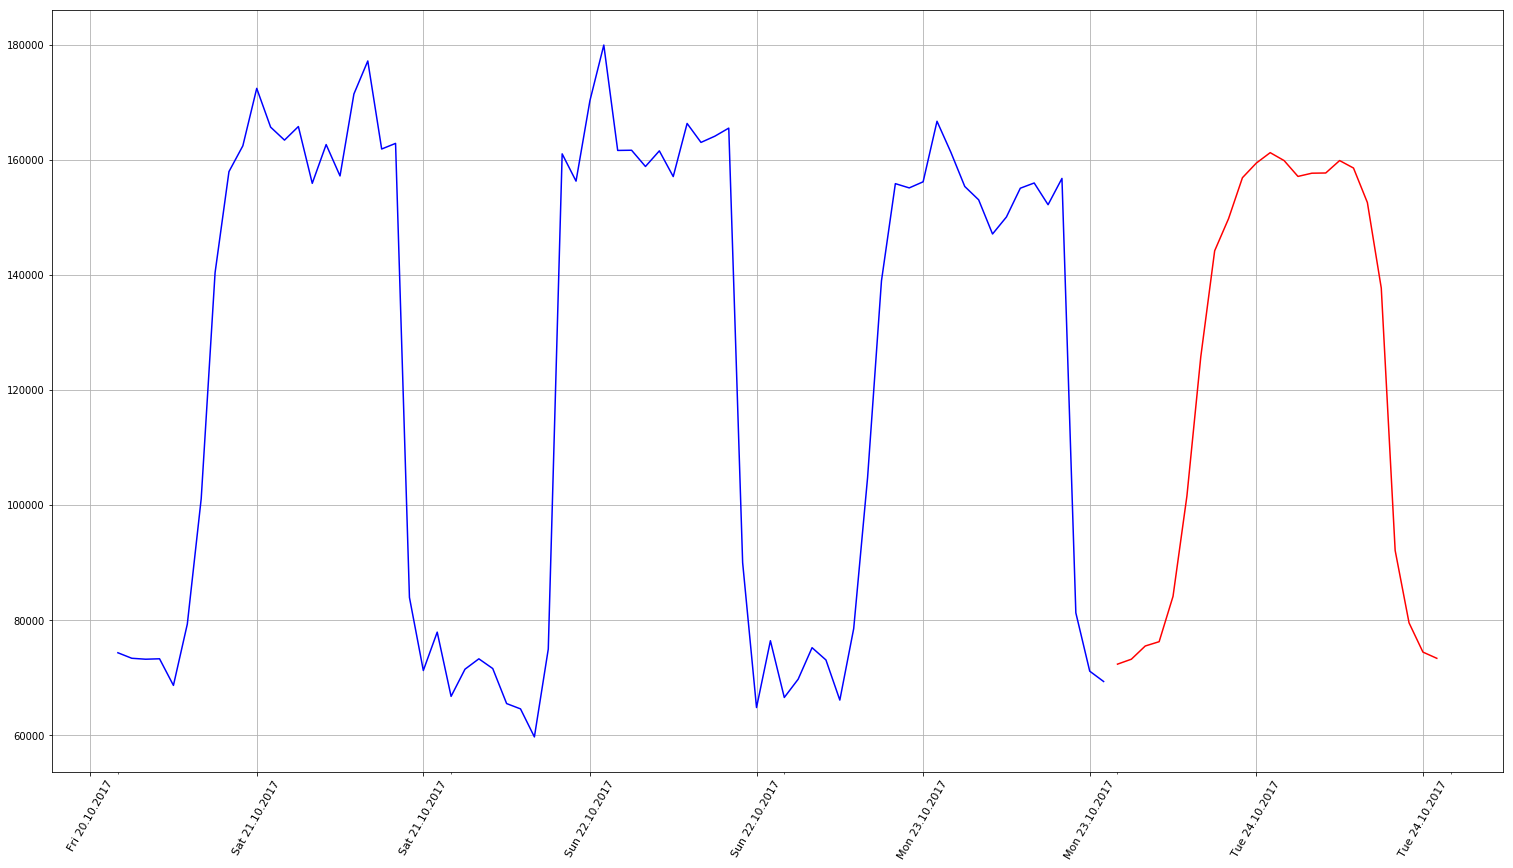

In [155]:
df1 = test[['series_id','timestamp','consumption']]
df2 = sub_original[['series_id','timestamp','consumption']]
#series_id = 103167 
#series_id = 102154
#series_id = 101427
#series_id = 102176
series_id = 100485
#series_id = 103343
#series_id = 100338
df1[df1.series_id == series_id].consumption
# start plotting
fig, ax = plt.subplots()
fig.figsize=(22,6)
plt.grid()
ax.xaxis.set_tick_params(rotation=60, labelsize=11)
plt.grid(True)
plt.plot(df1[df1.series_id == series_id].timestamp,np.ravel((df1[df1.series_id == series_id].consumption.values)),color='blue')
plt.plot(df2[df2.series_id == series_id].timestamp,np.ravel((df2[df2.series_id == series_id].consumption.values)),color='red')
myFmt = mdates.DateFormatter('%a %d.%m.%Y')
ax.xaxis.set_major_formatter(myFmt)
days = mdates.DayLocator()
ax.xaxis.set_minor_locator(days)

# plot sample daily prediction

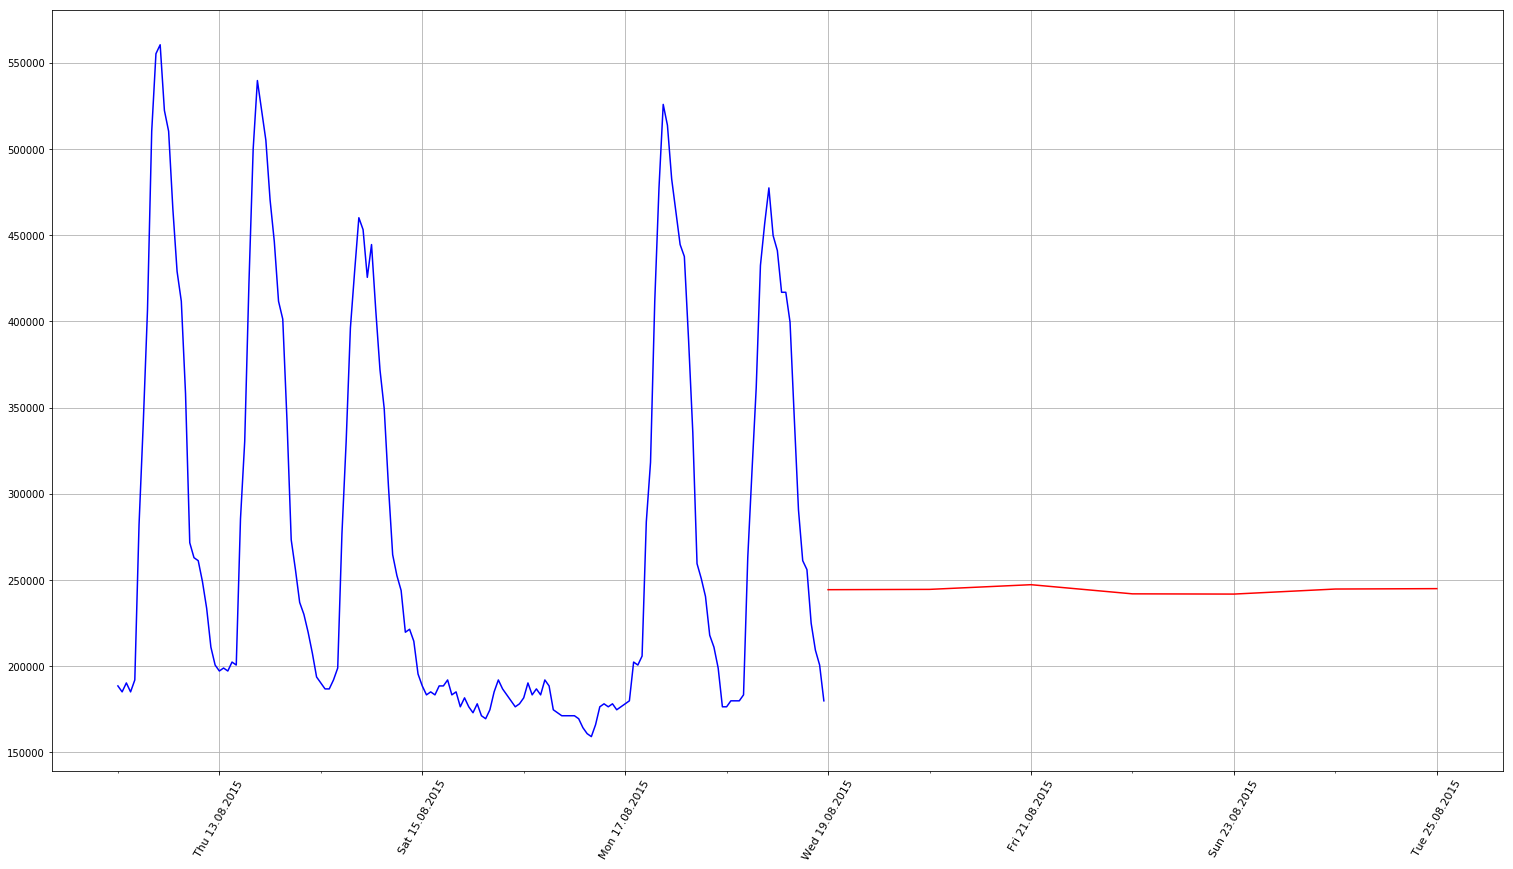

In [33]:
df1 = test[['series_id','timestamp','consumption']]
df2 = sub_original[['series_id','timestamp','consumption']]
#series_id = 103219
#series_id = 101464
#series_id = 102969
#series_id = 102176
series_id = 101275
#series_id = 102176
df1[df1.series_id == series_id].consumption
# start plotting
fig, ax = plt.subplots()
fig.figsize=(22,6)
plt.grid()
ax.xaxis.set_tick_params(rotation=60, labelsize=11)
plt.grid(True)
plt.plot(df1[df1.series_id == series_id].timestamp,np.ravel((df1[df1.series_id == series_id].consumption.values)),color='blue')
plt.plot(df2[df2.series_id == series_id].timestamp,np.ravel((df2[df2.series_id == series_id].consumption.values)),color='red')
myFmt = mdates.DateFormatter('%a %d.%m.%Y')
ax.xaxis.set_major_formatter(myFmt)
days = mdates.DayLocator()
ax.xaxis.set_minor_locator(days)

In [34]:
sub_original[sub_original.prediction_window =='daily']

,series_id,timestamp,temperature,consumption,prediction_window
pred_id,,,,,
0,102781,2013-03-03 00:00:00,19.931250,15604.711300,daily
1,102781,2013-03-04 00:00:00,20.034375,15604.711300,daily
2,102781,2013-03-05 00:00:00,19.189583,15604.711300,daily
3,102781,2013-03-06 00:00:00,18.397917,15604.711300,daily
4,102781,2013-03-07 00:00:00,20.762500,15604.711300,daily
5,102781,2013-03-08 00:00:00,19.800000,15604.711300,daily
6,102781,2013-03-09 00:00:00,20.466667,15604.711300,daily
7,103342,2013-06-26 00:00:00,10.486607,0.000000,weekly
8,103342,2013-07-03 00:00:00,10.006548,0.000000,weekly


# show data gap?

In [38]:
print('test series_id: 102781, last time stamp: ' + str(test_feed[test_feed.series_id == 102781].timestamp.max()))
print('|__sub series_id: 102781, first time stamp: ' + str(sub[sub.series_id == 102781].timestamp.min()))
print('|__sub series_id: 102781,  last time stamp: ' + str(sub[sub.series_id == 102781].timestamp.max()))

test series_id: 102781, last time stamp: 2013-03-02 23:00:00
|__sub series_id: 102781, first time stamp: 2013-03-03 00:00:00
|__sub series_id: 102781,  last time stamp: 2013-03-09 00:00:00
